This notebook works through the creation of a method for estimating the background in GALEX images.
It includes a lot of false starts for the purpose of documentation. The eventual result arrived at was similar to what is described in the (photutils documentation)[https://photutils.readthedocs.io/en/stable/aperture.html#sigma-clipped-median-within-a-circular-annulus], except with a little hack to calculate the "effective" area of the background annulus so that errors can be propagated accurately.

In [1]:
%pylab
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML # requires ffmpeg

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import photutils as pu
from astropy import stats
import scipy.ndimage as ndimage#import median_filter

In [4]:
import gfcat_utils as gfu

In [5]:
cntfilename = '../data/e13656/e13656-nd-cnt.fits.gz'
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


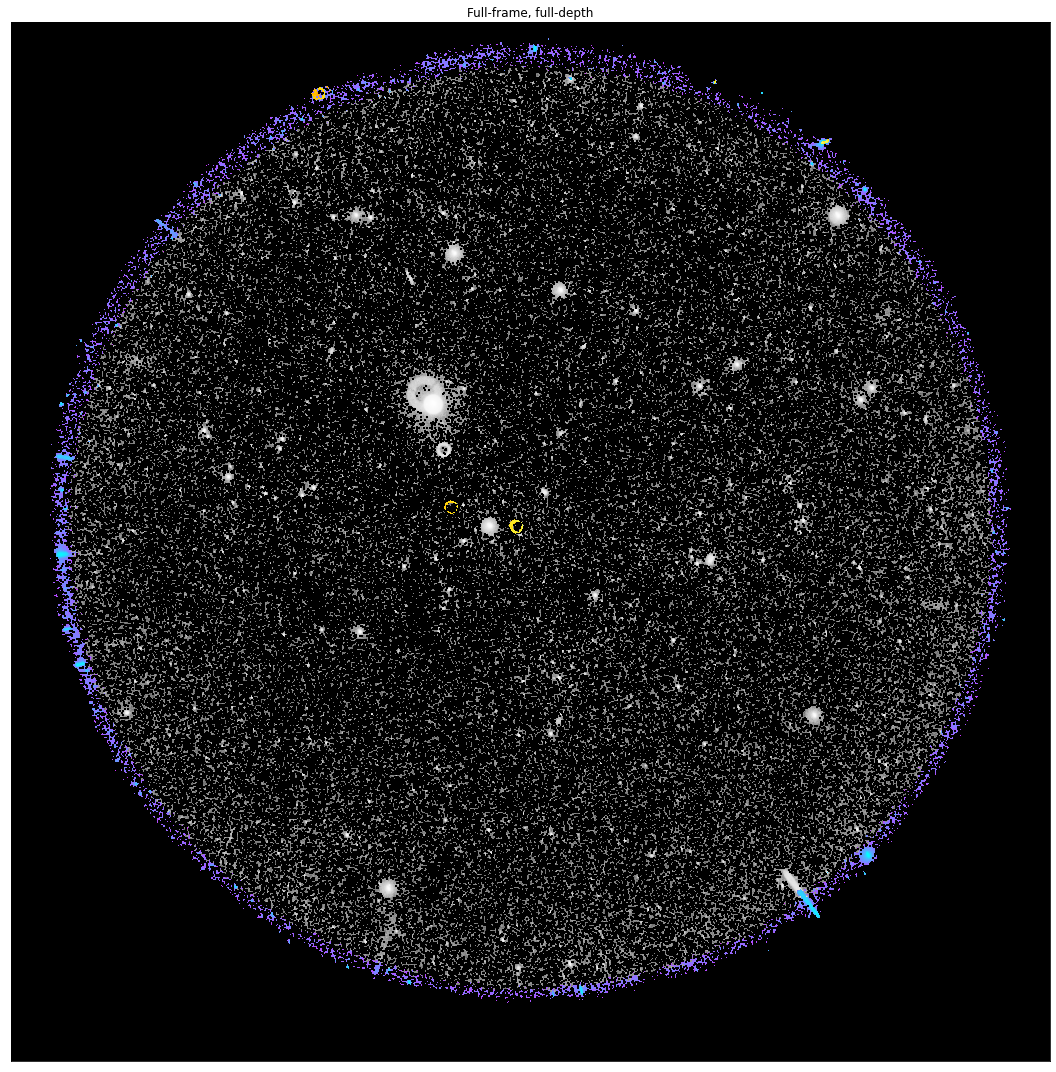

In [6]:
plt.figure(figsize=(15, 15))
plt.title('Full-frame, full-depth')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(cntmap), cmap="Greys", origin="lower")
plt.imshow(1/np.sqrt(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(1/np.sqrt(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
#pu.CircularAperture(positions, r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


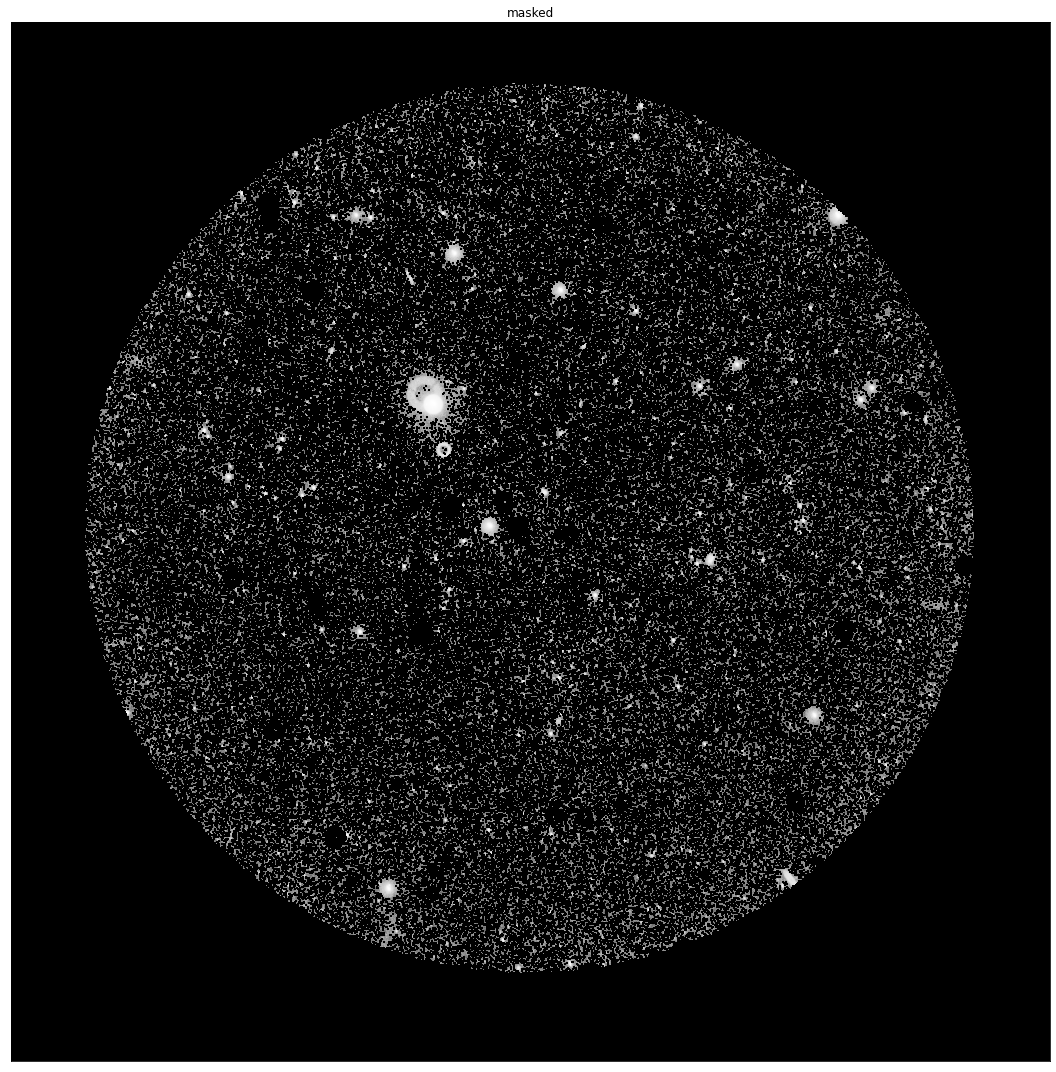

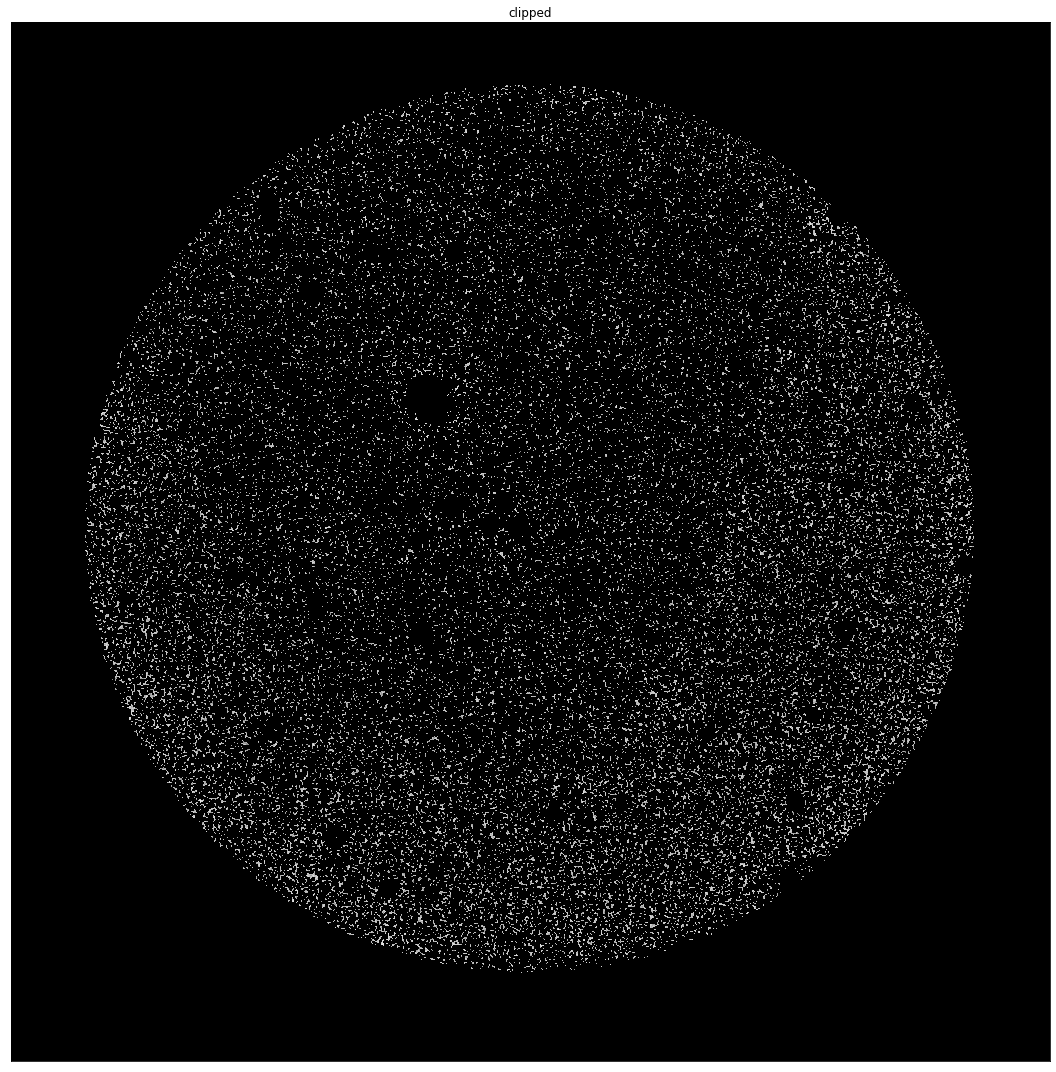

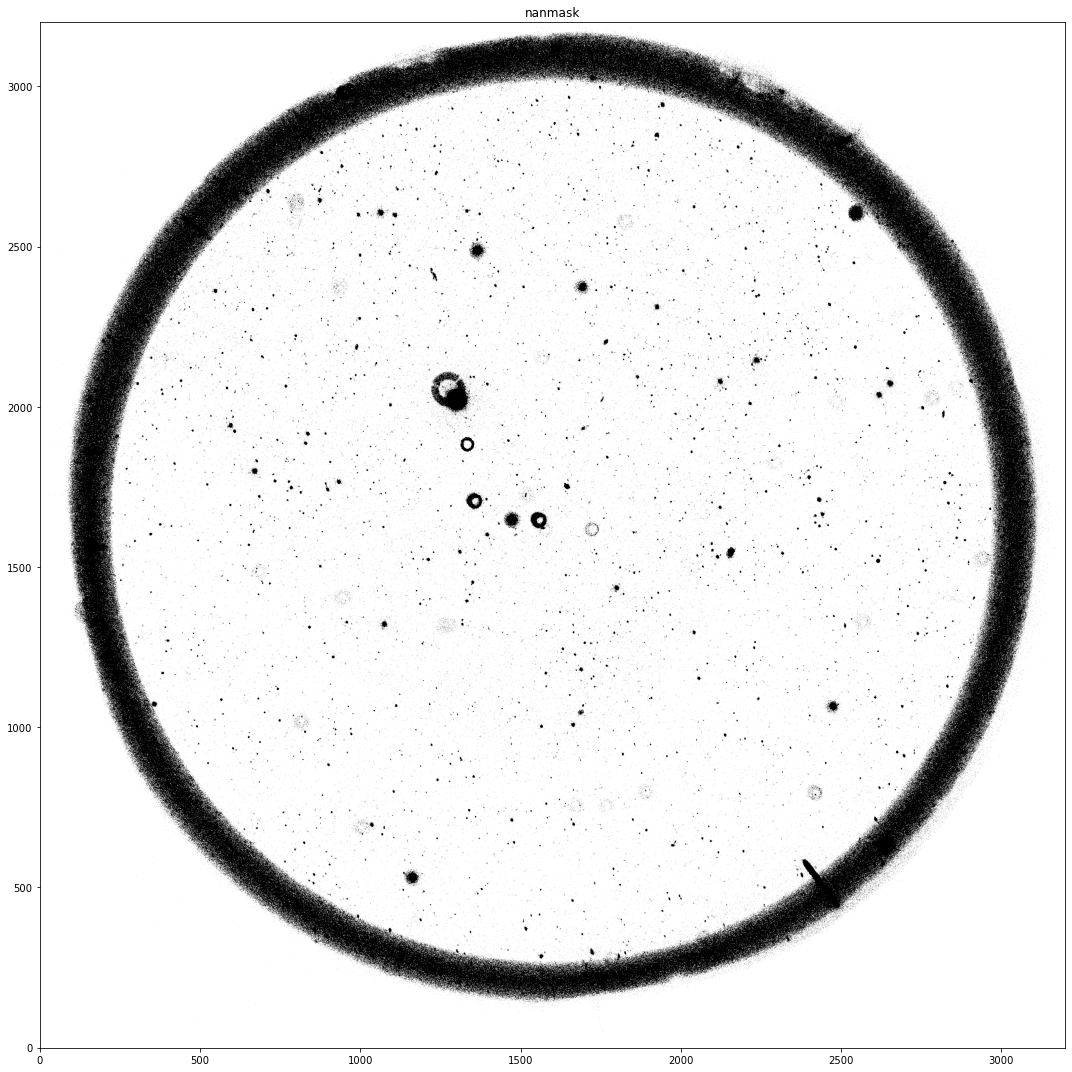

In [7]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
masked = cntmap
masked[np.where(edgemap)] = np.nan
masked[np.where(flagmap)] = np.nan
clipped = stats.sigma_clip(masked.flatten(),masked=False,axis=0,maxiters=10,sigma=3).reshape(masked.shape)

plt.figure(figsize=(15, 15))
plt.title('masked')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(masked), cmap="Greys", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(15, 15))
plt.title('clipped')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(clipped), cmap="Greys", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(15, 15))
plt.title('nanmask')
nanmask = np.zeros(np.shape(cntmap))
nanmask[np.where(np.isnan(clipped))] = 1
plt.imshow(nanmask, cmap="Greys", origin="lower")
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.
3.785075388062797
3.3640357729143617


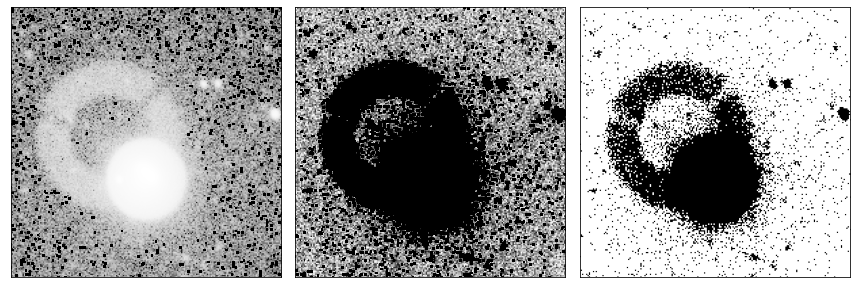

In [8]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
# Zoom in on just the brightest star, which might be biasing the skybg
# * Could be biasing it high due to unmasked light
# * Could be biasing it low due to local gain sag

box = [[1200,1400],[1950,2150]]

plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(masked), cmap="Greys", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.xlim(box[0])
plt.ylim(box[1])

plt.subplot(1,3,2)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(clipped, cmap="Greys", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.xlim(box[0])
plt.ylim(box[1])

plt.subplot(1,3,3)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(nanmask, cmap="Greys", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.xlim(box[0])
plt.ylim(box[1])

print(np.nanmean(masked[box[0][0]:box[0][1],box[1][0]:box[1][1]]))
print(np.nanmean(clipped[box[0][0]:box[0][1],box[1][0]:box[1][1]]))

This is an attempt to clone critical functionality of `poissonbg.c`.

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.
128.0 pixel skybg map.


(1600.0, 1728.0)

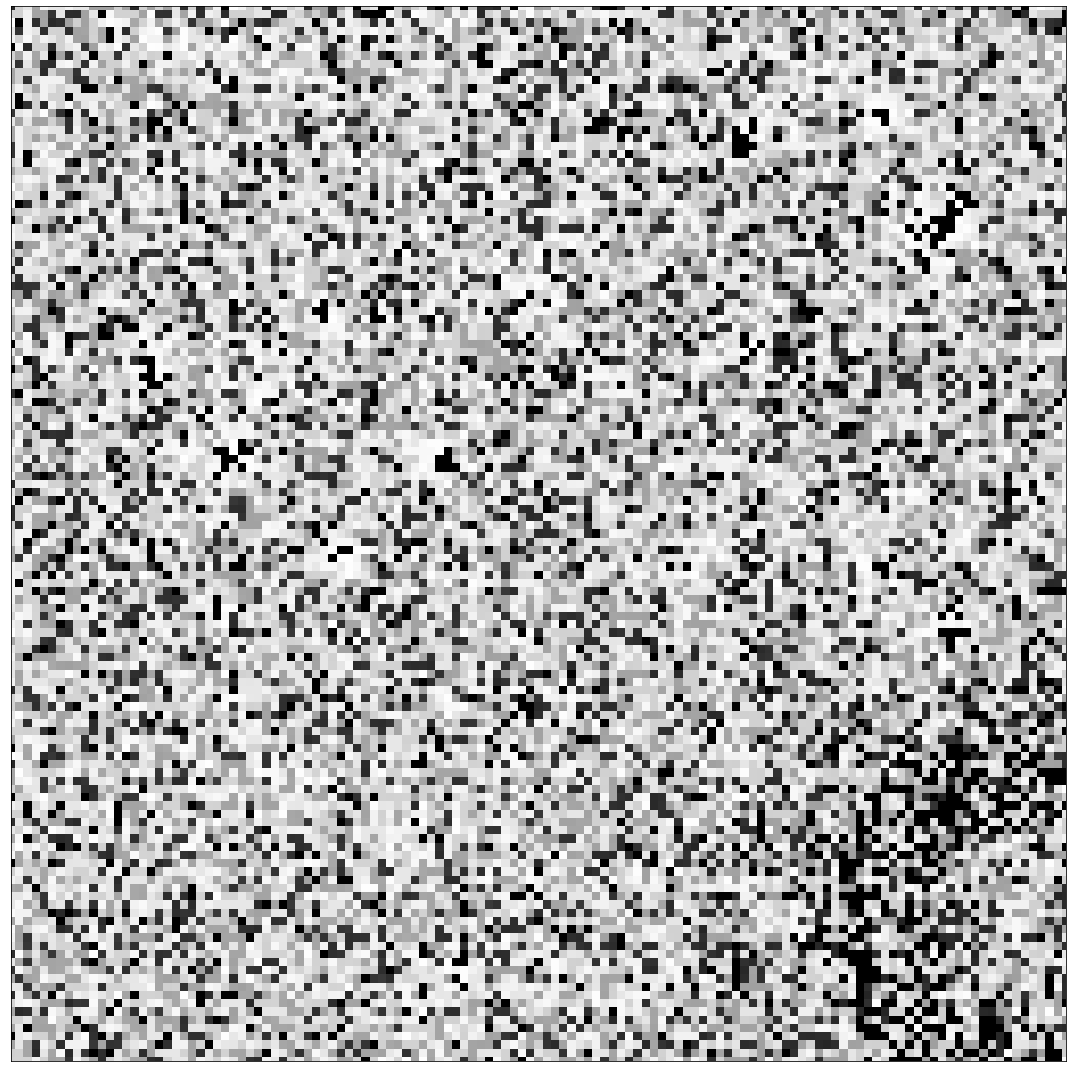

In [9]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(clipped), cmap="Greys", origin="lower")
#plt.imshow(1/np.sqrt(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
#plt.imshow(1/np.sqrt(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
#pu.CircularAperture(positions, r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# The mission used 192'' skybg pixels. The cnt pixels are 1.5''. Therefore...
print(f'{(boxsz := 192/1.5)} pixel skybg map.')
box = [[1600,int(1600+boxsz)],[1600,int(1600+boxsz)]]
plt.xlim(box[0])
plt.ylim(box[1])

In [10]:
clipped_box = clipped[box[0][0]:box[0][1],box[1][0]:box[1][1]]
np.nanmean(clipped_box)

3.581632095606703

In [11]:
def downsample(img,boxsz=128):
    # should check whether imdim is a multiple of boxsz
    newimg = np.zeros(np.array(np.array(img.shape)/boxsz,dtype='int16'))
    for x in np.arange(0,img.shape[0],boxsz):
        for y in np.arange(0,img.shape[1],boxsz):
            box = [[int(x),int(x+boxsz)],[int(y),int(y+boxsz)]]
            val = np.nanmean(img[box[0][0]:box[0][1],box[1][0]:box[1][1]])
            newimg[int(x/boxsz)][int(y/boxsz)] = val
    return newimg

def new_median_filter(img,size=5):
    newimg = np.zeros(np.array(np.array(img.shape),dtype='int16'))
    for x in np.arange(0,img.shape[0],boxsz):
        for y in np.arange(0,img.shape[1],boxsz):
            box = [[int(x),int(x+boxsz)],[int(y),int(y+boxsz)]]
            val = np.nanmedian(img[box[0][0]:box[0][1],box[1][0]:box[1][1]])
            newimg[int(x)][int(y)] = val
    return newimg

In [12]:
# This all takes a long time to run and doesn't give a good result.
#%time cnttest = ndimage.generic_filter(cntmap,np.nanmean,size=128)

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


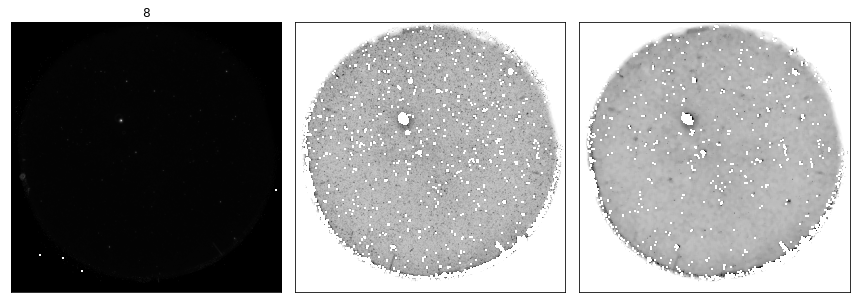

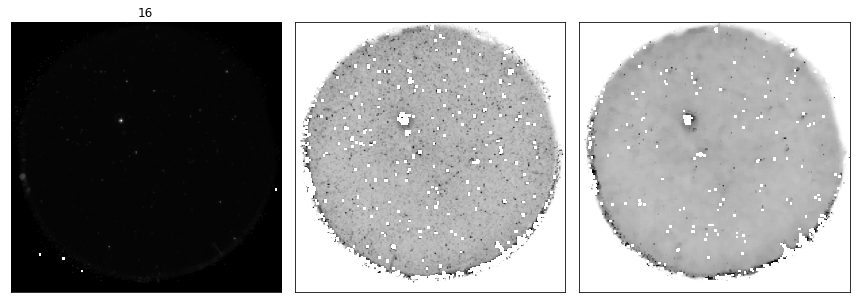

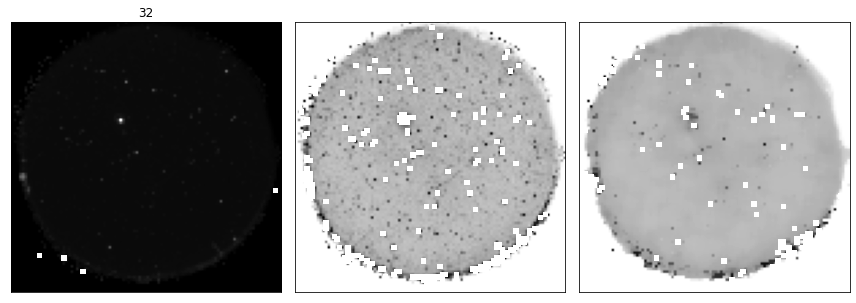

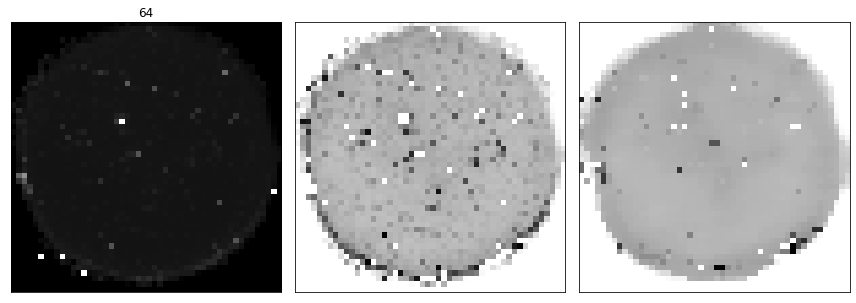

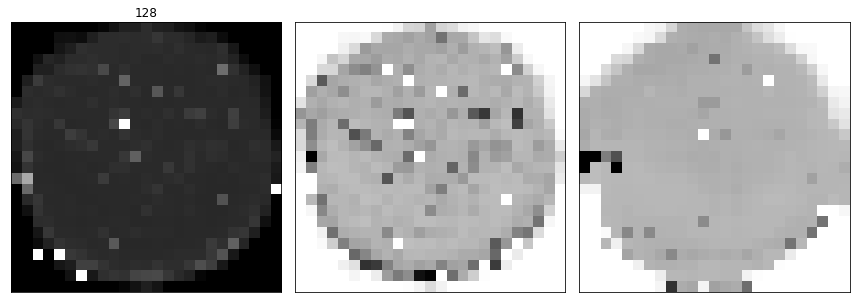

In [13]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
def make_skybg(img,boxsz=128):
    downsampled = downsample(img,boxsz=boxsz)
    clipped = stats.sigma_clip(downsampled.flatten(),masked=False,axis=0,maxiters=10).reshape(downsampled.shape)
    smoothed = ndimage.median_filter(clipped,size=5)
    return downsampled, clipped, smoothed

for boxsz in [8,16,32,64,128]:
    skybg=make_skybg(cntmap,boxsz=boxsz)

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.title(boxsz)
    plt.imshow(np.sqrt(skybg[0]),cmap="Greys_r", origin="lower")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.subplot(1,3,2)
    plt.imshow(skybg[1],cmap="Greys", origin="lower")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.subplot(1,3,3)
    plt.imshow(skybg[2],cmap="Greys", origin="lower")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


([], [])

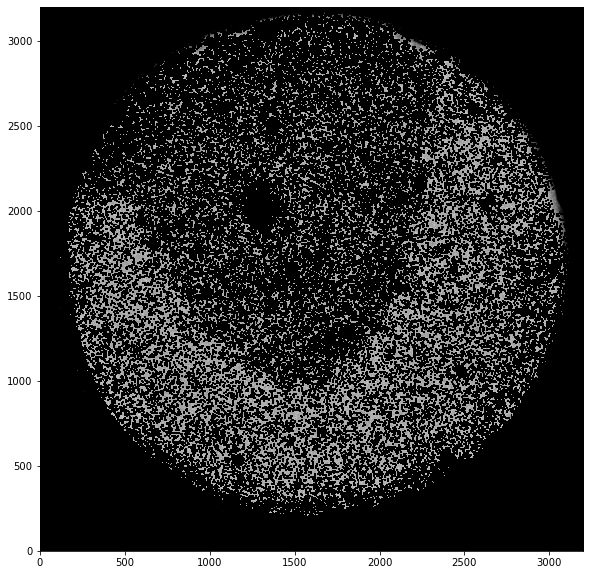

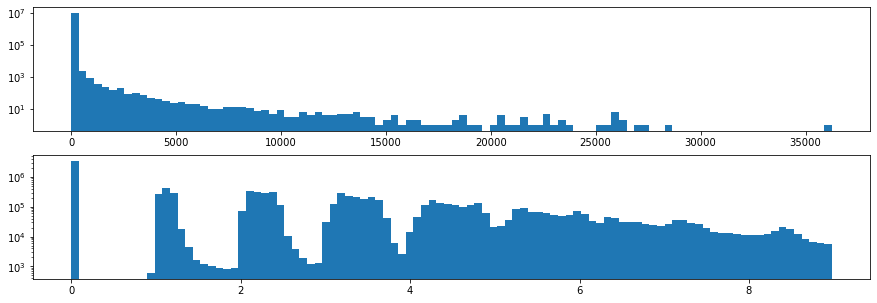

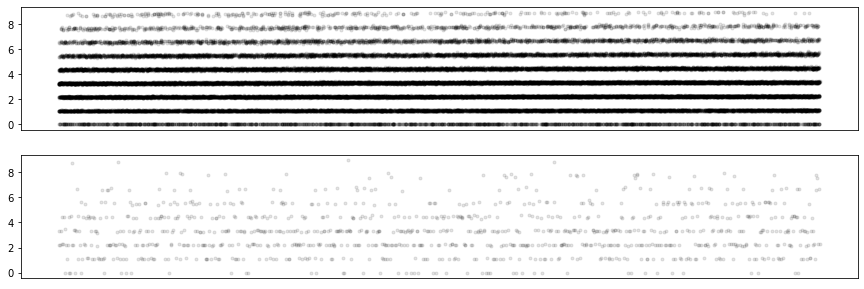

In [14]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
img = stats.sigma_clip(cntmap.flatten(),masked=False,axis=0,maxiters=10).reshape(cntmap.shape)
plt.figure(figsize=(10,10))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.sqrt(img),cmap="Greys_r", origin="lower")

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.hist(np.array(cntmap[np.where(np.isfinite(cntmap))]).flatten(),bins=100)
plt.semilogy()
plt.subplot(2,1,2)
plt.hist(img.flatten(),bins=100)
plt.semilogy()

#####
dist = img[1000:1200,1000:1200].flatten()
dist = dist[np.where(np.isfinite(dist))]

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(dist,'k.',alpha=0.1)
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(np.random.choice(dist,size=1000,replace=True),'k.',alpha=0.1)
plt.xticks([])

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


[]

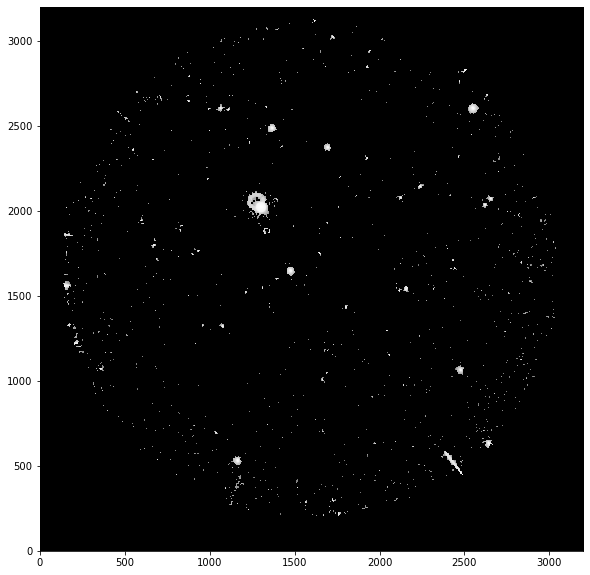

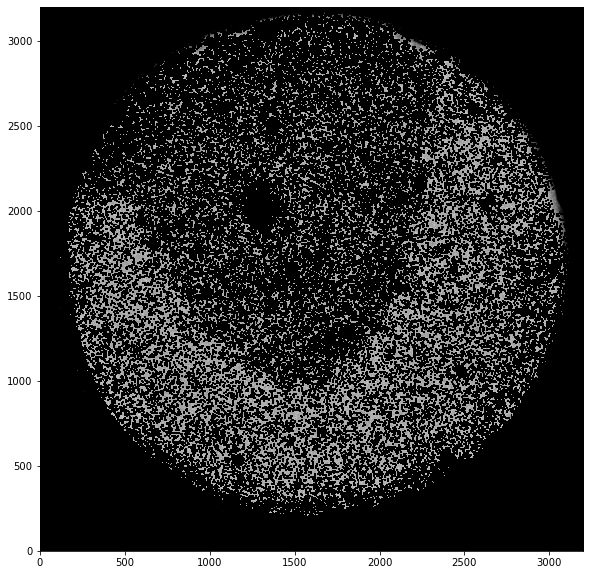

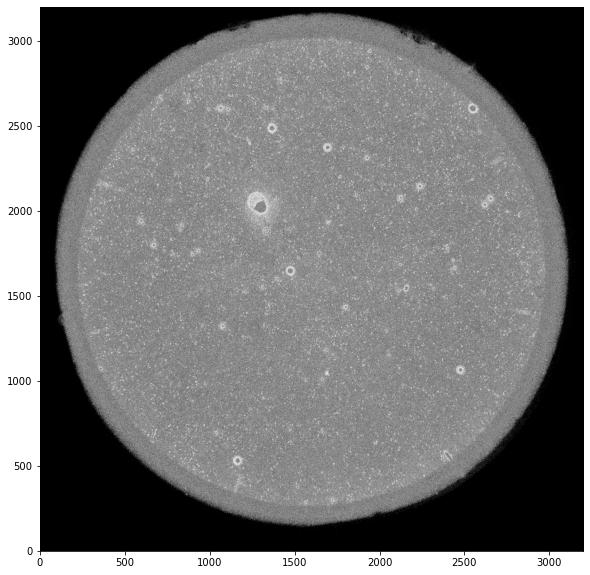

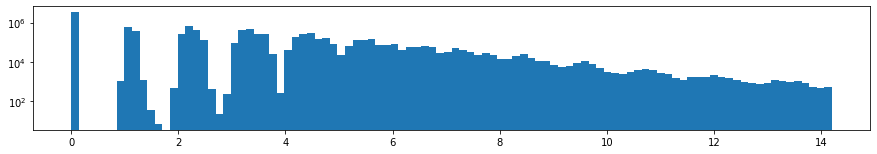

In [15]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
plt.figure(figsize=(10,10))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(cntmap),cmap="Greys", origin="lower")

img = stats.sigma_clip(cntmap.flatten(),masked=False,axis=0,maxiters=10).reshape(cntmap.shape)
plt.figure(figsize=(10,10))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.sqrt(img),cmap="Greys_r", origin="lower")

def patch_bg(cntmap, sz = 2):
    img = stats.sigma_clip(cntmap.flatten(),sigma=5,masked=False,axis=0,maxiters=10).reshape(cntmap.shape)
    img0 = np.zeros(img.shape)
    i=0
    while len(np.where(isnan(img))[0]):
        print(i:=i+1,len(np.where(isnan(img))[0]))
        for j,(x,y) in enumerate(zip(np.where(np.isnan(img))[0],np.where(np.isnan(img))[1])):
            if not j%10000:
                print(j)
            dist = img[x-sz:x+sz,y-sz:y+sz].flatten()
            dist = dist[np.where(np.isfinite(dist))]
            if not len(dist):
                continue
            val = np.random.choice(dist.flatten(),replace=True)
            img[x,y] = img0[x,y] = val
    return img, img0

img = cntmap
img[np.where(edgemap)] = 0
img[np.where(flagmap)] = np.nan
img = stats.sigma_clip(masked.flatten(),masked=False,axis=0,maxiters=10,sigma=5).reshape(masked.shape)
img[np.where(np.isnan(img))] = np.random.choice(dist.flatten(),size=len(np.where(isnan(img))[0]),replace=True)
plt.figure(figsize=(10,10))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.sqrt(img),cmap="Greys_r", origin="lower")

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.hist(img.flatten(),bins=100)
plt.semilogy()


In [16]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
mask = pu.make_source_mask(cntmap, nsigma=2, npixels=5, dilate_size=11)
print(stats.sigma_clipped_stats(cntmap, sigma=3.0, mask=mask))
mask[np.where(edgemap)] = True
mask[np.where(flagmap)] = True
print(stats.sigma_clipped_stats(cntmap, sigma=3.0, mask=mask))

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.
(1.905582173556821, 1.1640519546471455, 2.055098356642251)
(1.772705336107217, 1.0910024863033831, 2.0122580491665376)


500 pixel skybg map.


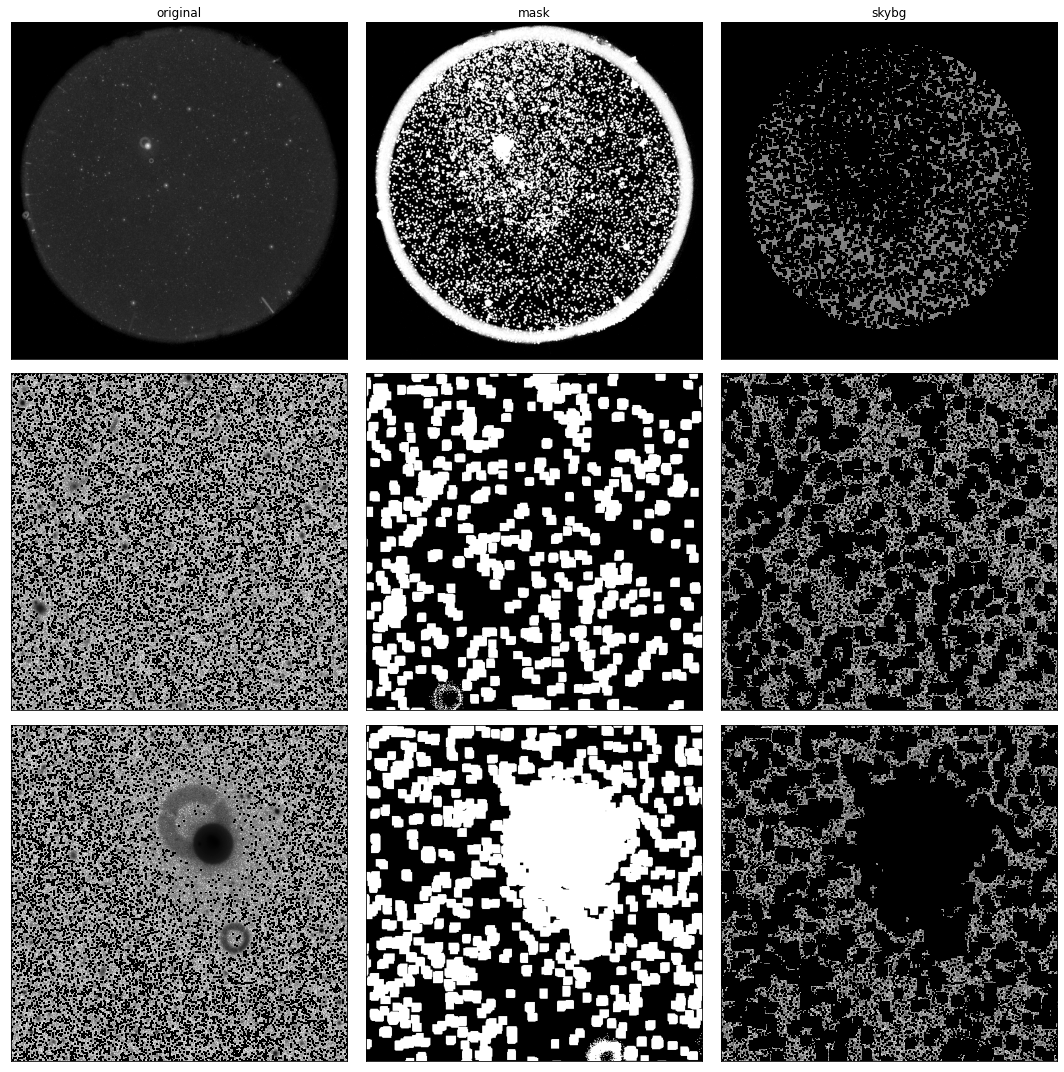

In [17]:
clipped = stats.sigma_clip(masked.flatten(),masked=False,axis=0,maxiters=10,sigma=3).reshape(masked.shape)
masked = np.ma.masked_array(cntmap,mask=mask)
masked.set_fill_value(np.nan)

####

plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.title('original')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(np.log10(cntmap+1),cmap="Greys_r", origin="lower")
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,2)
plt.title('mask')
plt.imshow(mask,cmap="Greys_r", origin="lower")
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,3)
plt.title('skybg')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(np.log10(masked+1),cmap="Greys_r", origin="lower")
plt.xticks([])
plt.yticks([])
plt.tight_layout()

####
impos = (1600,1600)
print(f'{(boxsz := 500)} pixel skybg map.')
box = [[impos[0],int(impos[0]+boxsz)],[impos[1],int(impos[1]+boxsz)]]

plt.subplot(3,3,4)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(cntmap),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,5)
plt.imshow(mask,cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,6)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(masked),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])
plt.tight_layout()

####
impos = (1000,1700)
box = [[impos[0],int(impos[0]+boxsz)],[impos[1],int(impos[1]+boxsz)]]

plt.subplot(3,3,7)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(cntmap),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,8)
plt.imshow(mask,cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,9)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(masked),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])
plt.tight_layout()

Simple background estimation from masked image...

	Background area: 1600 pixels
	Unmasked: 5274 pixels
	Counts: 3.427915236828358 +/- 0.03353629984579387
	Countrate: 0.002240909096555627 +/- 2.1923470738672628e-05


([], [])

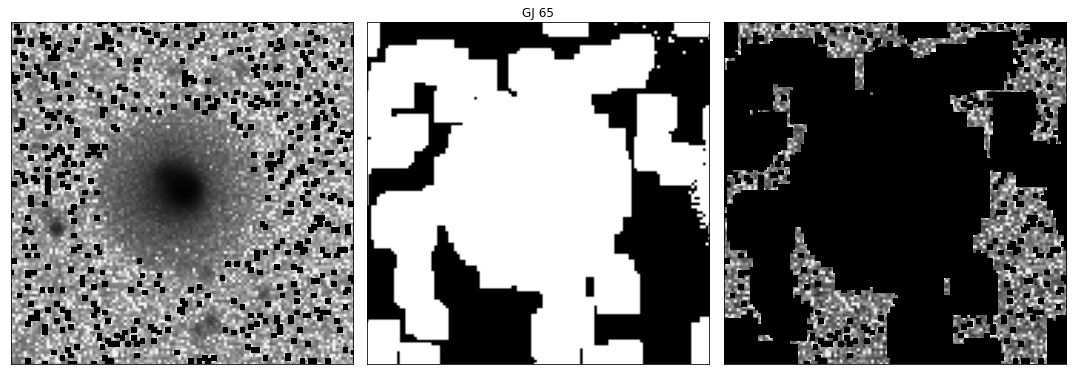

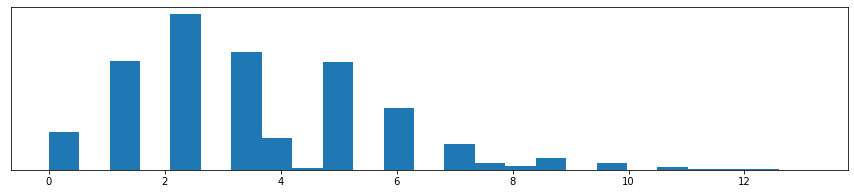

In [18]:
print('Simple background estimation from masked image...\n')
impos=(1475, 1647) # UV Ceti
sz = 60
#box = [[impos[0],int(impos[0]+boxsz)],[impos[1],int(impos[1]+boxsz)]]
box = [[int(impos[0]-sz),int(impos[0]+sz)],[int(impos[1]-sz),int(impos[1]+sz)]]

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(cntmap),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.title('GJ 65')
plt.imshow(mask,cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r", origin="lower")
plt.imshow(1/np.sqrt(masked),cmap="Greys_r", origin="lower")
plt.xlim(box[0])
plt.ylim(box[1])
plt.xticks([])
plt.yticks([])
plt.tight_layout()

bgreg = masked[impos[0]-sz:impos[0]+sz,impos[1]-sz:impos[1]+sz]
print(f'\tBackground area: {(20*2)**2} pixels')
print(f'\tUnmasked: {(npix:=len(np.where(bgreg.mask == True)[0]))} pixels')
print(f'\tCounts: {(cnt:=bgreg.mean())} +/- {(cnt_err:=np.sqrt(bgreg.sum())/npix)}')
print(f'\tCountrate: {cnt/exptime[0]} +/- {cnt_err/exptime[0]}')
plt.figure(figsize=(15,3))
plt.hist(bgreg.flatten(),bins=25)
plt.yticks([])

In [19]:
print('Test that the mask works with the CircularAnnulus function...')
annulus = pu.CircularAnnulus([impos],20,40)
print(pu.aperture_photometry(cntmap, annulus)[0]['aperture_sum'])
print((counts_bg:=pu.aperture_photometry(masked, annulus)[0]['aperture_sum']))

print('\nFigure out a way to calculate the effective area of the annulus (less the mask)...')
print(annulus.area,'<==>',
      pu.aperture_photometry(np.ones(cntmap.shape), annulus)[0]['aperture_sum'])
print((annulus_area:=pu.aperture_photometry(np.ones(cntmap.shape), annulus, mask=masked.mask)[0]['aperture_sum']))

Test that the mask works with the CircularAnnulus function...
21104.3268916856
2555.322360476621

Figure out a way to calculate the effective area of the annulus (less the mask)...
3769.9111843077517 <==> 3769.9111843077517
674.0043206495359


In [20]:
aperture = pu.CircularAperture([impos],5)
counts = pu.aperture_photometry(cntmap, aperture)[0]['aperture_sum']

In [21]:
print((cps:=counts/exptime[0]))
print((cps_err:=np.sqrt(counts)/exptime[0]))
print((cps_bg:=aperture.area*(counts_bg/annulus_area)/exptime[0]))

107.53116502465244
0.265133288263732
0.1946556712038364


In [22]:
def make_bg_mask(cntfilename):
    cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename) # read image
    mask = pu.make_source_mask(cntmap, nsigma=2, npixels=5, dilate_size=11) # aggressively sigma-cliip image
    mask[np.where(edgemap)] = True # mask out the edges
    mask[np.where(flagmap)] = True # mask out the hotspots
    masked = np.ma.masked_array(cntmap,mask=mask) # actually apply the mask to the image
    masked.set_fill_value(np.nan) # make the fill value play nicely with numpy
    return masked
    
def extract_bg(masked,impos,ann):
    annulus = pu.CircularAnnulus([impos],ann[0],ann[1])
    counts_bg=pu.aperture_photometry(masked, annulus)[0]['aperture_sum']
    area_eff=pu.aperture_photometry(np.ones(mask.shape), annulus, mask=masked.mask)[0]['aperture_sum']
    return counts_bg, area_eff

extract_bg(make_bg_mask(cntfilename),impos,(20,40))

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


(2555.322360476621, 674.0043206495359)